https://towardsdatascience.com/time-series-pattern-recognition-with-air-quality-sensor-data-4b94710bb290

# import libraries

In [630]:
%matplotlib inline

import boto3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
import pandas as pd
from scipy.stats import shapiro
from sklearn import preprocessing

In [631]:
import warnings
warnings.filterwarnings("ignore")

# import data from AWS

In [702]:
client = boto3.client('iotanalytics')
data = client.get_dataset_content(datasetName='airquality_1_dataset')
df = pd.read_csv(data["entries"][0]["dataURI"])
df = df[df["timestamp"] > "2021-05-26T00:00:00"]
df = df[df["timestamp"] < "2021-05-31T00:00:00"]
df.drop(["__dt"], axis = 1, inplace = True)
df["timestamp"] = pd.to_datetime(df["timestamp"]) + pd.Timedelta(hours=2)
df.set_index("timestamp", inplace = True)
df.sort_values(by="timestamp", axis=0, ascending=True, inplace=True)
#df = df.astype(int)
#df = df[df["ppm"] < 8000]
df.tail()

,temperature,pressure,ppm,humidity
timestamp,,,,
2021-05-31 01:55:26,19.82,977.69,3588.08,51.03
2021-05-31 01:56:26,19.79,977.60,3592.21,51.03
2021-05-31 01:57:26,19.80,977.63,3591.02,51.02
2021-05-31 01:58:26,19.82,977.52,3588.64,51.00
2021-05-31 01:59:26,19.81,977.52,3590.57,50.97


# Clean data

# filter outliers

In [703]:
def is_outlier(data):
    thresh = 100
    rolling_median = data.rolling(2, center=True).median()
    return (abs(data - rolling_median) >= thresh).astype('int')

In [704]:
ppm = df.drop(["temperature","pressure", "humidity"], axis = 1)
outlier = is_outlier(ppm)
ppm["outlier"] = outlier

old_len = len(ppm)
ppm =ppm[ppm["outlier"]==0]
new_len = len(ppm)
print("filtered: abs.", old_len-new_len, "rel.",int((1-old_len/new_len)*100), "%", "values")

ppm = ppm.drop(["outlier"], axis = 1)

filtered: abs. 101 rel. -1 % values


# plot Data

In [705]:
try:
    ppm_rolling = ppm.rolling(12)
    ppm_rolling_mean = ppm_rolling.mean()
    ppm_rolling_std = ppm_rolling.std()
    ppm_rolling_upper = ppm_rolling_mean + 1.92 * ppm_rolling_std
    ppm_rolling_lower = ppm_rolling_mean - 1.92 * ppm_rolling_std
    
except:
    pass

In [706]:
def create_const(df, value):
    arr = np.full((1, len(df)), value)[0]
    return pd.Series(arr, index = df.index)

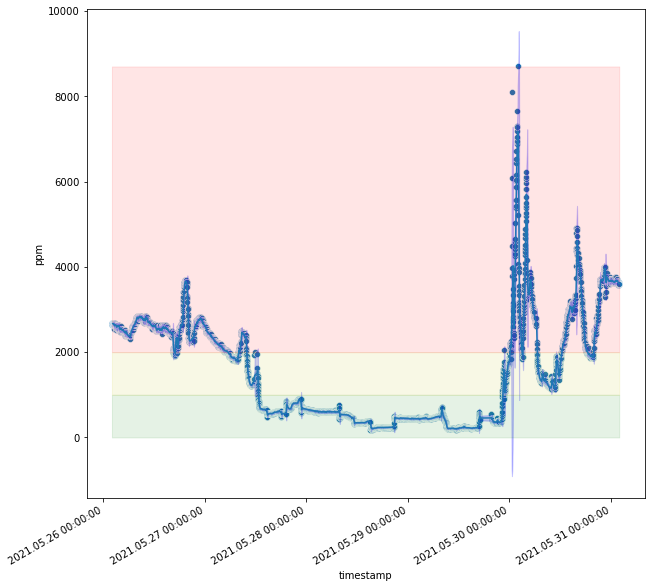

In [707]:
# build the figure
fig, ax = plt.subplots(figsize=(10,10))

#from matplotlib.pyplot import figure

sns.scatterplot(x = ppm.index, y="ppm", data = ppm, ax =ax)
sns.lineplot(x = ppm_rolling_mean.index, y="ppm", data = ppm_rolling_mean, ax =ax)
plt.fill_between(ppm_rolling_mean.index, ppm_rolling_upper['ppm'], ppm_rolling_lower['ppm'], color='b', alpha=.2)

# airquality



plt.fill_between(ppm_rolling_mean.index, create_const(ppm_rolling_mean, 1000), create_const(ppm_rolling_mean, 0), color='g', alpha=.1)
plt.fill_between(ppm_rolling_mean.index, create_const(ppm_rolling_mean, 1000), create_const(ppm_rolling_mean, 2000), color='y', alpha=.1)
plt.fill_between(ppm_rolling_mean.index, create_const(ppm_rolling_mean, 2000), create_const(ppm_rolling_mean, ppm_rolling.max().max()), color='r', alpha=.1)


# assign locator and formatter for the xaxis ticks.
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d %H:%M:%S'))

# put the labels at 45deg since they tend to be too long
fig.autofmt_xdate()
plt.show()


# Feature Engineering
- Kennzahlen einführen: meantime between good-good; bad-bad

# categorize data

## categorize ppm value
ppm < 1000: good; 
1000 >= ppm <= 2000: medium;
ppm > 2000: bad;

In [594]:
ppm_bins = [0, 1000, 2000, np.inf]
ppm_category = ['0', '1', '2']
ppm["quality"] = pd.cut(ppm['ppm'], ppm_bins, labels=ppm_category)

ppm["quality"].value_counts()

0    4058
2    3756
1    2266
Name: quality, dtype: int64

In [595]:
#ppm["good"] = (ppm["ppm"] < 1000).astype("int")
#ppm["medium"] = ((ppm["ppm"] >= 1000) & (ppm["ppm"] <= 2000)).astype("int")
#ppm["bad"] = (ppm["ppm"] > 2000).astype("int")

## categorize time
6 < morning < 12;
12 < noon < 18;
18 < evening < 24;
0 < night <6;

In [596]:
time_hour = ppm.index.strftime('%H').astype('int')
ppm["day"] = ppm.index.strftime('%A')#.astype('int')

time_bins = [0, 6, 12, 18, 24]
time_category = ['night', 'morning', 'noon', 'evening']
ppm["time"] = pd.cut(time_hour, time_bins, labels=time_category)

ppm.head()

,ppm,quality,day,time
timestamp,,,,
2021-05-25 09:19:23,1870.32,1,Tuesday,morning
2021-05-25 09:19:28,1870.01,1,Tuesday,morning
2021-05-25 09:19:34,1819.38,1,Tuesday,morning
2021-05-25 09:19:39,1819.46,1,Tuesday,morning
2021-05-25 09:19:44,1870.55,1,Tuesday,morning


In [597]:
#time_hour = ppm.index.strftime('%H').astype(int)

#ppm["morning"] = ((time_hour >= 6) & (time_hour < 12)).astype("int")
#ppm["noon"] = ((time_hour >= 12) & (time_hour < 18)).astype("int")
#ppm["evening"] = ((time_hour >= 18) & (time_hour < 24)).astype("int")
#ppm["night"] = ((time_hour >= 24) & (time_hour < 6)).astype("int")

# Time Series Modelling

In [598]:
X = ppm.drop(['ppm', "quality"], axis=1)
X = pd.get_dummies(X)
y = ppm["quality"]

In [599]:
from sklearn.model_selection import train_test_split

Xtrain, xtest, ytrain, ytest = train_test_split(X, y, random_state = 1)

In [600]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(Xtrain, ytrain)

LinearRegression()

In [601]:
x = df.index[-1]+pd.Timedelta(hours=1)

In [603]:
y_model = model.predict(X)

In [620]:
rolling = pd.Series(y_model, index = y.index).rolling(60).mean()

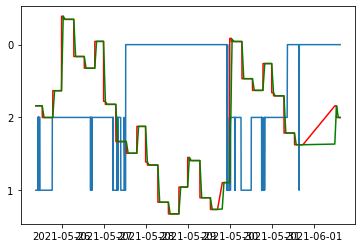

In [622]:
plt.plot(y.index, y, label="")
plt.plot(y.index, y_model, "r", label = "prediction")
plt.plot(rolling.index, rolling, "g")


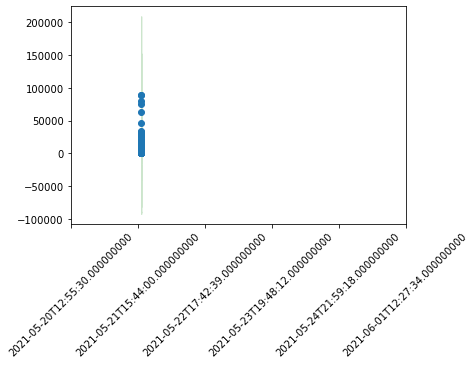

In [398]:
# roll over x minutes
# 
df_r = df.rolling(5)

t = 24*60*2#len(df)
df_rm = df_r.mean()[t:]
df_rs = df_r.std()[t:]
df_rupper = df_rm + 1.96*df_rs
df_rlower = df_rm - 1.96*df_rs

df_rmax = df_r.max()[:t]
df_rmin = df_r.min()[:t]

fig, ax = plt.subplots()
plt.fill_between(df_rm.index, df_rupper['ppm'], df_rlower['ppm'], color='g', alpha=.2)
values = ax.scatter(df_rm.index, 'ppm', data=df_rm)

myFmt = mdates.DateFormatter('%d')
ax.xaxis.set_major_formatter(myFmt)

i = int(len(df_rm)/5)

pos = np.arange(len(df_rm.index))
ticks = plt.xticks(pos[::i], df_rm.index.values[::i], rotation=45)

plt.show()